<a href="https://colab.research.google.com/github/ShengHangNB/Datasets/blob/master/ML_Assignment2_decision_tree_c4_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Machine Learning Assignment 2**






## **Implementation of algorithm - Decision Tree C4.5**

In [598]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [599]:
df = pd.read_csv("https://raw.githubusercontent.com/ShengHangNB/Datasets/master/iris.csv")
df.head()

,sepal length,sepal width,petal length,petal width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [600]:
def change_target_type(x):
  if x == 'Iris-setosa':
    return 0

  elif x == 'Iris-versicolor':
    return 1
  
  elif x == 'Iris-virginica':
    return 2

df.loc[:,"class"] = df["class"].apply(change_target_type)
df.head()

,sepal length,sepal width,petal length,petal width,class
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [601]:
# check whether thare are some null values for each attribute
df.isnull().any()

sepal length    False
sepal width     False
petal length    False
petal width     False
class           False
dtype: bool

In [602]:
# check the data type and non-null count values for each attribute
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal length  150 non-null    float64
 1   sepal width   150 non-null    float64
 2   petal length  150 non-null    float64
 3   petal width   150 non-null    float64
 4   class         150 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 6.0 KB


In [603]:
# Table of statistics for all numerical attributes:
df.describe()

,sepal length,sepal width,petal length,petal width,class
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667,1.000000
std,0.828066,0.433594,1.764420,0.763161,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


In [604]:
# get the attributes by using the df.keys() functions,
# then extract all the attributes except for the target name by using the slice method df.keys()[:-1]
attrs = df.keys()[:-1]
print("The attrbutes are: ")
for attr in attrs:
  print(attr)

print("\nThe target is ",df.keys()[-1])

The attrbutes are: 
sepal length
sepal width
petal length
petal width

The target is  class


In [605]:
# split the datasets into the attributes datasets (input) and target datasets (output)
# X: DataFrame type   y: Series type
print("The number of samples in the total datasets are {}\n".format(df.shape[0]))
X_total = df[attrs]
y_total = df.iloc[:,-1]

# For the features datasets,target datasets, split them into the training datasets and testing datasets respectively
# The training datasets accounts for 67% of the total datasets,
# The testing datasets acoounts for 33% of the total datasets
X_train, X_test, y_train, y_test = train_test_split(X_total, y_total, test_size = 0.33,random_state = 48)


print("The number of samples in the training datasets are {}".format(X_train.shape[0]))
print("The number of samples in the testing datasets are {}".format(X_test.shape[0]))

The number of samples in the total datasets are 150

The number of samples in the training datasets are 100
The number of samples in the testing datasets are 50


In [606]:
class Myutils:
  def get_split_pointSet(self,attr_series):
    '''
      功能:通过二分法将连续属性离散化处理
      array: 传入的一列属性的值，series类型
      返回值：所有划分点的集合,array类型
    '''
    unique_values = np.unique(attr_series)
    result = np.array([(unique_values[i] + unique_values[i+1]) / 2  for i in range(len(unique_values)-1)])

    return np.unique(result)
    
  def get_discrete_variables(self,X,attr,split_point):
    '''
      功能：将连续型变量通过分裂点转换为大于分裂点和小于分离点的离散型变量
      X: 传入的数据集, DataFrame
      attr: 需要分割的属性
      split_point：划分点/分割点
    '''
    bins_to_cut = [min(X[attr]),split_point,max(X[attr])]
    labels_to_cut = [attr + ' < ' + str(split_point), attr + ' > ' + str(split_point)]
    categorized_column = pd.cut(X[attr], bins= bins_to_cut , labels = labels_to_cut, include_lowest=True)
    return categorized_column

  def compute_entropy(self,y):
    '''
      功能：计算信息熵H(D)
      y: 传入的目标值series
      返回值：float类型的计算结果
    '''
    if len(y) < 2:
      return 0.0
      
    freq = y.value_counts(normalize=True)
      
    return -(freq * np.log2(freq + 1e-6)).sum()

  def compute_info_gain_ratio(self,X,y,attr,split_point_list):
    '''
      计算连续型变量中特定属性的单个分裂点的信息增益
        
      X：包含属性的数据集, DataFrame类型
      y：包含目标值的数据集, Series类型
      attr: 要计算信息增益的属性，字符串类型
      split_point_lst: 分割点，float类型
        
      返回值：信息增益率计算结果，float类型; 最优划分点：float类型
        
    '''

    best_split_point = 0.0
    best_info_gain = 0.0
    split_entropy = 0.0

    if len(split_point_list) == 0:
      return 0, None

    else:
      for split_point in split_point_list:
        lower_index_boolean = X[attr] < split_point
        lower_X = X[lower_index_boolean]
        lower_y = y[lower_index_boolean]
        
        upper_index_boolean = X[attr] > split_point
        upper_X = X[upper_index_boolean]
        upper_y = y[upper_index_boolean]
        
        Ent_D = compute_entropy(y)
        
        lower_p = len(lower_X) / len(X)
        upper_p = len(upper_X) / len(X)

        lowersets_entropy = lower_p * compute_entropy(lower_y)
        uppersets_entropy = upper_p * compute_entropy(upper_y)   
        
        info_gain = Ent_D - (lowersets_entropy + uppersets_entropy)

        categorized_column = get_discrete_variables(X,attr,split_point)

        split_entropy = compute_entropy(categorized_column)

        if info_gain > best_info_gain:
          best_info_gain = info_gain
          best_split_point = split_point
            
      info_gain_ratio = best_info_gain / split_entropy
      return info_gain_ratio, best_split_point

utils = Myutils()

In [607]:
class TreeNode:
  def __init__(self,X,y, node_name="", default_decision=None):
    self.children = {}
    self.split_point = 0.0
    self.name = node_name
    self.split_attr = None
    self.default_decision = default_decision
    self.decision = None
    self.split_point_info = []
    self.attrs_info_gain_ratio = {}
    self.X = X
    self.y = y

  def pretty_print(self,prefix=''):
    number = len(self.X)
    if self.split_attr is not None:
      for k,v in self.children.items():
        v.pretty_print(f"{prefix}: When {self.split_attr} is {k} ({str(number)} values)")
    else:
      print(f"{prefix}: Determining the decision -> {self.decision} ({str(number)} values)")

  def print_node_details(self):
    time = 1

    if self.split_attr is not None:
      for k,v in self.children.items():
        
        if len(self.split_point_info) != 0:
          if time != 1:
            print("Back to the node: ",self.name)
          else:
            print("First view of the node: ",self.name)

          print("The number of the samples in this node is: ", len(self.X))
          print()
          for i,j in self.attrs_info_gain_ratio.items():          
            print("{}'s information gain ratio is: {}".format(i,j))

          print("\nSplited by {}, its information gain ratio is {}, its splited points list is:\n {}".format(self.split_point_info[1][1],self.split_point_info[1][2],self.split_point_info[0]))
          print("Among these splited points, the best splited point is {}".format(self.split_point_info[1][0]))
          print("The child node is: {}".format(k))
          print('--------------------------------------------------------------------')
          time += 1

          v.print_node_details()
          
             
    else:
      time += 1
      print("This node is: {}, it is a leaf node".format(self.name))
      print("The number of samples is: ", len(self.X))
      print("Determining the decision -> ",self.decision)
      print('--------------------------------------------------------------------')

  def make(self):
    if self.default_decision is None:
      self.default_decision = self.y.mode()[0]


    if len(self.X) == 0:
      self.decision = self.default_decision
      # print("Specially determining the decision ->", self.decision)
      return

    else:
      target_unique_values = self.y.unique()
      if len(target_unique_values) == 1:
        self.decision = target_unique_values[0]
        return

      else:
        max_infoGain_rate = 0.0
        best_split_point = 0.0
        best_split_point_list = []
        for attr in self.X.keys():
          split_point_list = utils.get_split_pointSet(self.X[attr])
          if len(split_point_list) == 0:
            # No split point here, which means that this attritbue has only one type of value
            continue

          else:
            infoGain_rate,splited_point = utils.compute_info_gain_ratio(self.X, self.y, attr, split_point_list)
            self.attrs_info_gain_ratio[attr] = infoGain_rate
            if infoGain_rate > max_infoGain_rate:
              max_infoGain_rate = infoGain_rate
              self.split_attr = attr
              best_split_point_list = split_point_list
              best_split_point = splited_point

        self.split_point_info.append(list(best_split_point_list))
        self.split_point_info.append([best_split_point,self.split_attr,max_infoGain_rate])
        self.split_point = best_split_point

        if self.split_point != 0.0:

          X_copy = self.X.copy()
          discrete_class = self.split_attr + '-group'
          X_copy.loc[:,discrete_class] = utils.get_discrete_variables(X_copy,self.split_attr,self.split_point)
          
          for value in X_copy[discrete_class].unique():
            index_boolean = X_copy[discrete_class] == value
            self.children[value] = TreeNode(
                              self.X[index_boolean],
                              self.y[index_boolean],
                              node_name = value,
                              default_decision=self.default_decision,)
            
            self.children[value].make()
        
        else:
          y_mode = self.y.mode()

          if len(y_mode) == 1:
            better_decision = y_mode[0]
            self.decision = better_decision

          else:
            decision = y_mode[0]
            print("Issues happen!")
            print("These samples have the same Input values but different target values")
            print("Input values: ")
            print(self.X)
            print("Target values: ")
            print(self.y)
            print("Just make a decision -> ", decision)
            print("------------------------------------------------------------------------------------------------------------")
            self.decision = decision
          return


In [608]:
class TreeC4_5:
  def __init__(self,X_values,y_values):
    self.root = None
    self.X = X_values
    self.y = y_values

  def fit(self):
    self.root = TreeNode(self.X,self.y, node_name="Root node")
    self.root.make()

  def predict(self,samples):
    decision_list = []
    for sample_index in range(len(samples)):
      sample = samples.iloc[sample_index]
      decision = self.make_decision(sample) 
      decision_list.append(decision)
    return np.array(decision_list)

  def make_decision(self,sample):
    current_node = self.root
    while current_node.decision is None:
      attribute_to_split = current_node.split_attr
      attribute_value = sample[attribute_to_split]
      
      if attribute_value > current_node.split_point:
        next_attr = current_node.split_attr + ' > ' + str(current_node.split_point)
      
      else:
        next_attr = current_node.split_attr + ' < ' + str(current_node.split_point)
          
      current_node = current_node.children[next_attr]

    return current_node.decision

In [609]:
dtc4_5 = TreeC4_5(X_train,y_train)
dtc4_5.fit()

In [610]:
dtc4_5.root.pretty_print('Brief node splited information')

Brief node splited information: When petal length is petal length < 2.45 (100 values): Determining the decision -> 0 (37 values)
Brief node splited information: When petal length is petal length > 2.45 (100 values): When petal length is petal length < 4.85 (63 values): When petal width is petal width < 1.65 (31 values): Determining the decision -> 1 (30 values)
Brief node splited information: When petal length is petal length > 2.45 (100 values): When petal length is petal length < 4.85 (63 values): When petal width is petal width > 1.65 (31 values): Determining the decision -> 2 (1 values)
Brief node splited information: When petal length is petal length > 2.45 (100 values): When petal length is petal length > 4.85 (63 values): When petal length is petal length < 5.15 (32 values): When petal width is petal width > 1.7000000000000002 (11 values): Determining the decision -> 2 (7 values)
Brief node splited information: When petal length is petal length > 2.45 (100 values): When petal le

In [611]:
dtc4_5.root.print_node_details()

First view of the node:  Root node
The number of the samples in this node is:  100

sepal length's information gain ratio is: 6.8934238847206615
sepal width's information gain ratio is: 4.3838465045386945
petal length's information gain ratio is: 11.767139096485085
petal width's information gain ratio is: 4.890555797161814

Splited by petal length, its information gain ratio is 11.767139096485085, its splited points list is:
 [1.05, 1.15, 1.25, 1.35, 1.45, 1.55, 1.65, 1.7999999999999998, 2.45, 3.15, 3.4, 3.55, 3.6500000000000004, 3.75, 3.8499999999999996, 3.95, 4.05, 4.15, 4.25, 4.35, 4.45, 4.55, 4.65, 4.75, 4.85, 4.95, 5.05, 5.15, 5.25, 5.35, 5.45, 5.55, 5.65, 5.75, 5.85, 5.95, 6.05, 6.199999999999999, 6.35, 6.5, 6.65, 6.800000000000001]
Among these splited points, the best splited point is 2.45
The child node is: petal length < 2.45
--------------------------------------------------------------------
This node is: petal length < 2.45, it is a leaf node
The number of samples is:  37
D

In [612]:
decisions = dtc4_5.predict(X_test)
results = decisions == y_test
accuracy = sum(results) / len(results)
print("My model's accuracy is: ", accuracy)

My model's accuracy is:  0.96


In [613]:
in_errs = []
out_errs = []
train_size = 0.66
for random_seed in range(10):
    # Randomly split training/test data
    X_trn, X_val, y_trn, y_val = train_test_split(
        X_total, y_total, train_size=train_size, random_state=random_seed)
    
    # Re-make a data model in each experiment
    dt = TreeC4_5(X_trn,y_trn)
    dt.fit() 
    
    # append the in/out error rates to the corresponding book-keeping
    in_sample_error_rate = np.sum((dt.predict(X_trn) != y_trn)) / len(y_trn)
    out_sample_error_rate = np.sum((dt.predict(X_val) != y_val)) / len(y_trn)
    # arrays
    # in_errs.append("Insert your code here")
    in_errs.append(in_sample_error_rate)
    # out_errs.append("Insert your code here")
    out_errs.append(out_sample_error_rate)

in_errs = np.array(in_errs)
out_errs = np.array(out_errs)
print(f"in_errs: mean {in_errs.mean():.2f}, std {in_errs.std():.2f}")
print(f"out_errs: mean {out_errs.mean():.2f}, std {out_errs.std():.2f}")

in_errs: mean 0.00, std 0.00
out_errs: mean 0.03, std 0.02


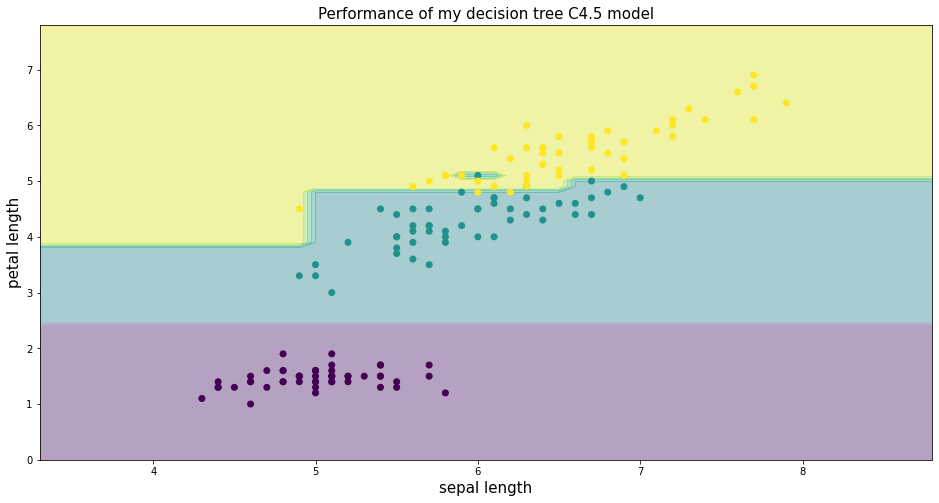

In [614]:
separated_attr_X_total = X_total.iloc[:,[0,2]]

separated_X_train = X_train.iloc[:,[0,2]]
dt = TreeC4_5(separated_X_train,y_train)

dt.fit()

x_min, x_max = separated_attr_X_total.iloc[:, 0].min() - 1, separated_attr_X_total.iloc[:, 0].max() + 1
y_min, y_max = separated_attr_X_total.iloc[:, 1].min() - 1, separated_attr_X_total.iloc[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

separeted_attribute1 = separated_X_train.keys()[0]
separeted_attribute2 = separated_X_train.keys()[1]

separated_X_test = pd.DataFrame({separeted_attribute1: xx.ravel(), separeted_attribute2: yy.ravel()})

Z = np.array(dt.predict(separated_X_test))

Z = Z.reshape(xx.shape)
plt.figure(figsize=(16,8))
plt.title("Performance of my decision tree C4.5 model", fontdict={"fontsize":15})
plt.xlabel(separeted_attribute1, fontsize=15)
plt.ylabel(separeted_attribute2, fontsize=15)
plt.contourf(xx, yy, Z,alpha=0.4)
plt.scatter(separated_attr_X_total.iloc[:, 0], separated_attr_X_total.iloc[:, 1], c = y_total)
plt.show()

## **Comparison with the Decision Tree Model in sklearn library**




In [578]:
from sklearn import tree 
import graphviz   

clf = tree.DecisionTreeClassifier(criterion="entropy",random_state=35)
clf = clf.fit(X_train,y_train)
decisions = clf.predict(X_test)
result = [decision == target for decision,target in zip(decisions,y_test)]
accuracy = sum(result)/len(result)
print("sklearn decision tree model's accuracy is:",accuracy)

sklearn decision tree model's accuracy is: 0.94


In [579]:
in_errs = []
out_errs = []
train_size = 0.66
for random_seed in range(10):
    # Randomly split training/test data
    X_trn, X_val, y_trn, y_val = train_test_split(
        X_total, y_total, train_size=train_size, random_state=random_seed)
    
    # Re-make a data model in each experiment
    dt = tree.DecisionTreeClassifier(criterion="entropy")
    dt.fit(X_trn, y_trn) 
    
    # append the in/out error rates to the corresponding book-keeping
    in_sample_error_rate = np.sum((dt.predict(X_trn) != y_trn)) / len(y_trn)
    out_sample_error_rate = np.sum((dt.predict(X_val) != y_val)) / len(y_trn)
    # arrays
    # in_errs.append("Insert your code here")
    in_errs.append(in_sample_error_rate)
    # out_errs.append("Insert your code here")
    out_errs.append(out_sample_error_rate)

in_errs = np.array(in_errs)
out_errs = np.array(out_errs)
print(f"in_errs: mean {in_errs.mean():.2f}, std {in_errs.std():.2f}")
print(f"out_errs: mean {out_errs.mean():.2f}, std {out_errs.std():.2f}")

in_errs: mean 0.00, std 0.00
out_errs: mean 0.03, std 0.01


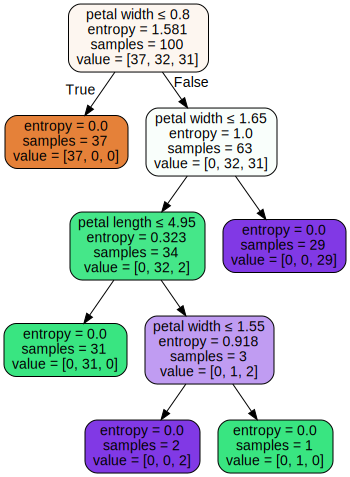

In [580]:
dot_data = tree.export_graphviz(clf,out_file=None,feature_names=list(X_train.columns.values),filled=True,rounded=True,special_characters=True)
graphOfTree = graphviz.Source(dot_data)
graphOfTree

**Evaluation dataset 1**

In [581]:
df2 = pd.read_csv("https://raw.githubusercontent.com/ShengHangNB/Datasets/master/transfusion.csv")
# df2 = df2.sample(n=450,random_state=50,axis=0)
df2.head()

,Recency (months),Frequency (times),Monetary (c.c. blood),Time (months),whether he/she donated blood in March 2007
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0


In [582]:
attrs2 = df2.keys()[:-1]
print("The number of samples in the total datasets are {}\n".format(df2.shape[0]))
X_total2 = df2[attrs2]
y_total2 = df2.iloc[:,-1]

X_train2, X_test2, y_train2, y_test2 = train_test_split(X_total2, y_total2, test_size = 0.33,random_state = 48)


print("The number of samples in the training datasets are {}".format(X_train2.shape[0]))
print("The number of samples in the testing datasets are {}".format(X_test2.shape[0]))

The number of samples in the total datasets are 748

The number of samples in the training datasets are 501
The number of samples in the testing datasets are 247


In [583]:
dt2 = TreeC4_5(X_train2,y_train2)
dt2.fit()

Issues happen!
These samples have the same Input values but different target values
Input values: 
     Recency (months)  Frequency (times)  Monetary (c.c. blood)  Time (months)
712                14                  2                    500             35
434                14                  2                    500             35
Target values: 
712    1
434    0
Name: whether he/she donated blood in March 2007, dtype: int64
Just make a decision ->  0
------------------------------------------------------------------------------------------------------------
Issues happen!
These samples have the same Input values but different target values
Input values: 
     Recency (months)  Frequency (times)  Monetary (c.c. blood)  Time (months)
332                16                  6                   1500             35
331                16                  6                   1500             35
Target values: 
332    1
331    0
Name: whether he/she donated blood in March 2007, dtype: int6

In [584]:
decisions = dt2.predict(X_test2)
results = decisions == y_test2
accuracy = sum(results) / len(results)
print("My model's accuracy is: ", accuracy)

My model's accuracy is:  0.708502024291498


In [585]:
clf2 = tree.DecisionTreeClassifier(criterion="entropy",random_state=35)
clf2 = clf2.fit(X_train2,y_train2)
decisions = clf2.predict(X_test2)
result = [decision == target for decision,target in zip(decisions,y_test2)]
accuracy = sum(result)/len(result)
print("Decision tree model's accuracy in sklearn library is:",accuracy)

Decision tree model's accuracy in sklearn library is: 0.7246963562753036


**Evaluation dataset 2**

In [586]:
df3 = pd.read_csv("https://raw.githubusercontent.com/ShengHangNB/Datasets/master/winequality-red.csv")

df3 = df3.sample(n=750, random_state=50, axis=0)

def change_target_type(x):
  if x > 6.5:
    return 'good'

  else:
    return 'not good'

df3.loc[:,"quality"] = df3["quality"].apply(change_target_type)
df3.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
453,10.4,0.33,0.63,2.8,0.084,5.0,22.0,0.99980,3.26,0.74,11.2,good
1415,6.2,0.58,0.00,1.6,0.065,8.0,18.0,0.99660,3.56,0.84,9.4,not good
1242,9.0,0.40,0.41,2.0,0.058,15.0,40.0,0.99414,3.22,0.60,12.2,not good
885,8.9,0.75,0.14,2.5,0.086,9.0,30.0,0.99824,3.34,0.64,10.5,not good
488,11.6,0.32,0.55,2.8,0.081,35.0,67.0,1.00020,3.32,0.92,10.8,good


In [587]:
attrs3 = df3.keys()[:-1]
print("The number of samples in the total datasets are {}\n".format(df3.shape[0]))
X_total3 = df3[attrs3]
y_total3 = df3.iloc[:,-1]

X_train3, X_test3, y_train3, y_test3 = train_test_split(X_total3, y_total3, test_size = 0.33,random_state = 48)


print("The number of samples in the training datasets are {}".format(X_train3.shape[0]))
print("The number of samples in the testing datasets are {}".format(X_test3.shape[0]))

The number of samples in the total datasets are 750

The number of samples in the training datasets are 502
The number of samples in the testing datasets are 248


In [588]:
dt3 = TreeC4_5(X_train3,y_train3)
dt3.fit()

In [589]:
decisions = dt3.predict(X_test3)
results = decisions == y_test3
accuracy = sum(results) / len(results)
print("My model's accuracy is: ", accuracy)

My model's accuracy is:  0.875


In [590]:
clf3 = tree.DecisionTreeClassifier(criterion="entropy",random_state=35)
clf3 = clf3.fit(X_train3,y_train3)
decisions = clf3.predict(X_test3)
result = [decision == target for decision,target in zip(decisions,y_test3)]
accuracy = sum(result)/len(result)
print("Decision tree model's accuracy in sklearn library is:",accuracy)

Decision tree model's accuracy in sklearn library is: 0.8588709677419355
